# 2.5.1 クロスエントロピーによる学習

In [ ]:
import torch
from torch import nn

p1 = torch.tensor([1.0, 0.0, 0.0])
p2 = torch.tensor([0.7, 0.2, 0.1])
p3 = torch.tensor([0.1, 0.2, 0.7])

cross_entropy = nn.CrossEntropyLoss()
print(cross_entropy(p1, p2))
print(cross_entropy(p1, p3))

# 2.5.2 Padding マスク と Subsequent マスク

In [ ]:
from torch import Tensor


def create_padding_mask(pad_id: int, batch_tokens: Tensor):
    # batch_tokens.shape == (batch_size, sequence_length)
    mask = batch_tokens == pad_id
    mask = mask.unsqueeze(1)
    return mask

In [ ]:
# パディングマスクの動作確認
batch_size = 3
sequence_length = 5
tokens = torch.Tensor([[5, 3, 3, 0, 0], [1, 9, 4, 3, 1], [5, 3, 5, 1, 0]])
padding_id = 0
score = torch.randn(batch_size, sequence_length, sequence_length)
mask = create_padding_mask(padding_id, tokens)
print(mask.shape)  # torch.Size([3, 1, 5])
masked_score = score.masked_fill(mask, float("-inf"))
print(masked_score[0])

In [ ]:
def create_subsequent_mask(batch_tokens: Tensor):
    sequence_len = batch_tokens.size(1)
    mask = torch.triu(
        torch.full((sequence_len, sequence_len), 1),
        diagonal=1,
    )
    mask = mask == 1
    mask = mask.unsqueeze(0)
    return mask

In [ ]:
# 後続マスクの動作確認
batch_size = 3
sequence_length = 5
tokens = torch.randn(batch_size, sequence_length)
score = torch.randn(batch_size, sequence_length, sequence_length)
mask = create_subsequent_mask(tokens)
print(mask.shape)  # torch.Size([3, 5, 5])
masked_score = score.masked_fill(mask, float("-inf"))
print(masked_score[0])

# 2.5.3 Transformer の学習

In [ ]:
from pathlib import Path


data_dir = Path("small_parallel_enja")
if not data_dir.exists():
    !git clone https://github.com/odashi/small_parallel_enja.git {data_dir}

train_ja = data_dir / "train.ja.000"
train_en = data_dir / "train.en.000"

In [ ]:
from typing import Iterator

from torchtext.vocab import build_vocab_from_iterator


def iter_corpus(
    path: Path,
    bos: str | None = "<bos>",
    eos: str | None = "<eos>",
) -> Iterator[list[str]]:
    with path.open("r") as f:
        for line in f:
            if bos:
                line = bos + " " + line
            if eos:
                line = line + " " + eos
            yield line.split()


train_tokens_ja = [tokens for tokens in iter_corpus(train_ja)]
train_tokens_en = [tokens for tokens in iter_corpus(train_en)]

In [ ]:
print(train_tokens_ja[:3])
print(train_tokens_en[:3])

In [ ]:
vocab_ja = build_vocab_from_iterator(
    iterator=train_tokens_ja,
    specials=("<unk>", "<pad>", "<bos>", "<eos>"),
)
vocab_ja.set_default_index(vocab_ja["<unk>"])
vocab_en = build_vocab_from_iterator(
    iterator=train_tokens_en,
    specials=("<unk>", "<pad>", "<bos>", "<eos>"),
)
vocab_en.set_default_index(vocab_en["<unk>"])

In [ ]:
print("<unk>:", vocab_ja["<unk>"])
tokens = ["<bos>", "吾輩", "は", "猫", "で", "ある", "<eos>"]
for token in tokens:
    print(vocab_ja[token], end=" ")

In [ ]:
from torch.utils.data import DataLoader
from torchtext import transforms

src_transforms = transforms.Sequential(
    transforms.VocabTransform(vocab_ja),
    transforms.ToTensor(padding_value=vocab_ja["<pad>"]),
)
tgt_transforms = transforms.Sequential(
    transforms.VocabTransform(vocab_en),
    transforms.ToTensor(padding_value=vocab_en["<pad>"]),
)


def collate_fn(batch: Tensor) -> tuple[Tensor, Tensor]:
    src_texts, tgt_texts = [], []
    for s, t in batch:
        src_texts.append(s)
        tgt_texts.append(t)

    src_texts = src_transforms(src_texts)
    tgt_texts = tgt_transforms(tgt_texts)

    return src_texts, tgt_texts

In [ ]:
train_loader = DataLoader(
    list(zip(train_tokens_ja, train_tokens_en)),
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
)

In [ ]:
# batch = next(iter(train_loader))
# src_texts, tgt_texts = batch
# print(src_texts.shape)
# print(tgt_texts.shape)

In [ ]:
import torch

from llm_from_scratch.transformer.transformer import Transformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, "を使用")

embedding_dim = 512
n_blocks = 6
n_heads = 8
expansion_rate = 1

# 語彙数を取得
src_vocab_size = len(vocab_ja)
tgt_vocab_size = len(vocab_en)

# 最も長い文章の長さを取得
max_len_ja = len(max(train_tokens_ja, key=lambda x: len(x)))
max_len_en = len(max(train_tokens_en, key=lambda x: len(x)))
max_length = max(max_len_ja, max_len_en)

model = Transformer(
    src_vocab_size,
    tgt_vocab_size,
    max_sequence_len=max_length,
    d_model=embedding_dim,
    n_blocks=n_blocks,
    n_heads=n_heads,
    d_k=embedding_dim,
    d_v=embedding_dim,
    d_ff=embedding_dim * expansion_rate,
).to(device)

In [ ]:
from torch import nn

PAD_ID = vocab_ja["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)  # クロスエントロピー
lr = 0.0001  # 学習率
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10.0, gamma=0.95)

In [ ]:
def train(model: nn.Module, log_interval: int = 10) -> list[float]:
    model.train()
    loss_history = []
    for i, (src_texts, tgt_texts) in enumerate(train_loader):
        # tgt の入力は最後の単語を除く
        tgt_input = tgt_texts[:, :-1]
        # tgt の出力は最初の単語を除く
        tgt_output = tgt_texts[:, 1:]
        src_padding_mask = create_padding_mask(PAD_ID, src_texts)
        tgt_padding_mask = create_padding_mask(PAD_ID, tgt_input)
        tgt_subsequent_mask = create_subsequent_mask(tgt_input)
        tgt_mask = tgt_padding_mask + tgt_subsequent_mask
        # Tensor のデバイスを設定
        src_texts, tgt_input, tgt_output = (
            src_texts.to(device),
            tgt_input.to(device),
            tgt_output.to(device),
        )
        src_padding_mask, tgt_mask = src_padding_mask.to(device), tgt_mask.to(device)

        # モデル出力を取得
        out = model(src_texts, tgt_input, src_padding_mask, tgt_mask, src_padding_mask)
        # 出力と教師データを1次元に変換
        out_flat = out.view(-1, out.size(-1))
        tgt_flat = tgt_output.flatten()
        # 誤差関数を計算
        loss = criterion(out_flat, tgt_flat)
        optimizer.zero_grad()
        # 誤差逆伝播
        loss.backward()
        optimizer.step()
        if (i + 1) % log_interval == 0:
            print(f"step {i+1}: train loss = {loss.item()}")
        loss_history.append(loss.item())
    return loss_history

In [ ]:
from tqdm.auto import tqdm

n_epochs = 20  # エポック数
pbar = tqdm(total=n_epochs)
for epoch in range(n_epochs):
    pbar.update(1)
    pbar.set_description(desc="Epoch")
    train(model)

In [ ]:
# 保存
torch.save(model.state_dict(), "transformer.pth")

In [ ]:
# 読み込み
model.load_state_dict(torch.load("transformer.pth"))

In [ ]:
text = "<bos> 今日 の 天気 は 晴れ です 。 <eos>"
tokens = text.split()
input_tokens = src_transforms([tokens]).to(device)
tgt_tokens = model.inference(
    input_tokens, bos_token=vocab_en["<bos>"], eos_token=vocab_en["<eos>"]
)
itos = vocab_en.get_itos()
text = " ".join(itos[token_id] for token_id in tgt_tokens[0])
print(text)

# 発展的な生成

In [ ]:
from torch.nn import functional as F


def beam_search_inference(
    model: nn.Module,
    src: Tensor,
    bos_token: int,
    eos_token: int,
    beam_width: int = 5,
    max_length: int = 50,
) -> Tensor:
    device = src.device
    encoder_output = model.encoder(src)

    # 初期状態の作成
    sequences = [[bos_token]]
    scores = torch.zeros(1, device=device)
    ended_seq_mask = [False]

    for _ in range(max_length):
        all_candidates = []
        for i in range(len(sequences)):
            seq = sequences[i]
            if ended_seq_mask[i]:
                # 既に終了しているシーケンスはそのまま保持
                all_candidates.append((scores[i], seq))
                continue

            tgt = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
            decoder_output = model.decoder(tgt, encoder_output)
            logits = model.linear(decoder_output[:, -1, :])
            log_probs = F.log_softmax(logits, dim=-1)

            # 現在のスコアと次のトークンの確率を足して全候補を生成
            for j in range(log_probs.size(1)):
                candidate = seq + [j]
                candidate_score = scores[i] + log_probs[0, j]
                all_candidates.append((candidate_score, candidate))

        # ビーム幅でソートしてトップ beam_width 個を選択
        top_candidates = sorted(all_candidates, key=lambda tup: tup[0], reverse=True)[
            :beam_width
        ]
        sequences = [x[1] for x in top_candidates]
        scores = torch.tensor([x[0] for x in top_candidates], device=device)
        ended_seq_mask = [seq[-1] == eos_token for seq in sequences]

        # 全ての候補が終了トークンで終わっている場合、終了
        if all(ended_seq_mask):
            break

    # スコアが最も高い候補を選択して出力
    best_sequence = sequences[0]
    return torch.tensor(best_sequence, device=device)

In [ ]:
text = "<bos> 今日 の 天気 は 晴れ です 。 <eos>"
tokens = text.split()
input_tokens = src_transforms([tokens]).to(device)
tgt_tokens = beam_search_inference(
    model, input_tokens, vocab_en["<bos>"], vocab_en["<eos>"], max_length=20
)
itos = vocab_en.get_itos()
text = " ".join(itos[token_id] for token_id in tgt_tokens)
print(text)  # <bos> the weather is fine today . <eos>

In [3]:
import numpy as np


def softmax(x: np.array, temperature: float) -> np.array:
    x = x / temperature
    x = np.exp(x)
    return x / np.sum(x)

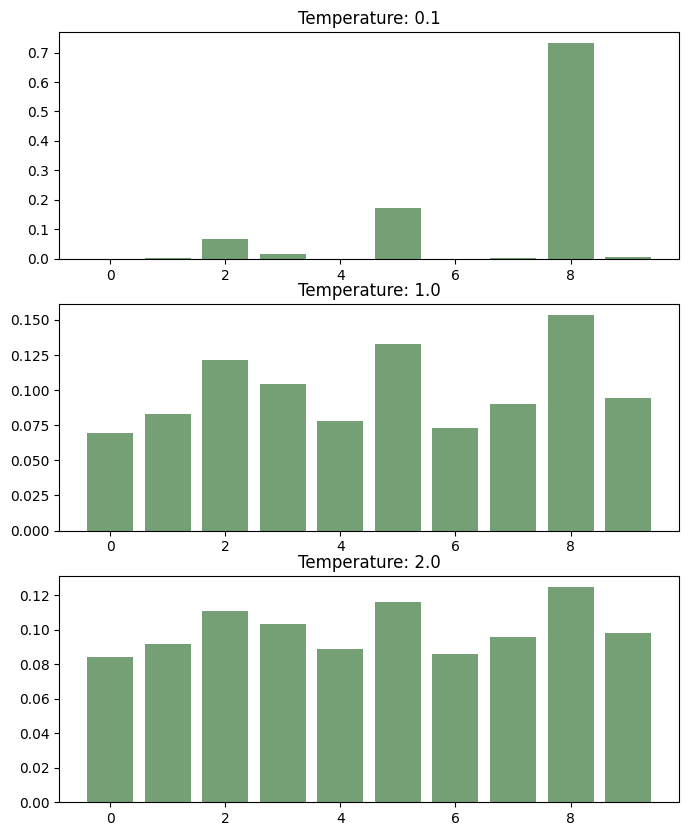

In [25]:
import matplotlib.pyplot as plt

GREEN = "#75a075"
temperature = [0.1, 1.0, 2.0]
fig, axes = plt.subplots(len(temperature), 1, figsize=(8, 10))
score = np.random.rand(10)
bins = np.arange(len(score))
for t, ax in zip(temperature, axes):
    prob = softmax(score, t)
    # 確率のヒストグラムを描画
    ax.bar(bins, prob, color=GREEN)
    ax.set_title(f"Temperature: {t}")

fig.savefig("softmax_temperature.png", dpi=300, bbox_inches="tight")

In [ ]:
def temperature_inference(
    model: nn.Module,
    src: Tensor,
    bos_token: int,
    eos_token: int,
    temperature: float = 1.0,
    max_length: int = 50,
):
    tgt_tokens = torch.tensor([[bos_token]]).to(src.device)

    encoder_output = model.encoder(src)
    for _ in range(max_length):
        decoder_output = model.decoder(tgt_tokens, encoder_output)
        score = model.linear(decoder_output)
        # 温度パラメータによる変換
        score = score / temperature
        porbability = F.softmax(score[0, -1], dim=-1)
        # トークンをサンプリング
        pred = torch.multinomial(porbability, 1)
        tgt_tokens = torch.cat((tgt_tokens, pred), axis=-1)
        if pred[0, 0].item() == eos_token:
            break

    return tgt_tokens